Let's take a look at some card-level data, courtesy of mtgjson.
Here's specifically where to find what I'm using:
https://mtgjson.com/downloads/all-files/

In [3]:
data_path = '/Users/connorkenehan/Documents/GitHub/gathering-data/data/AllPrintings.json.zip'
import pandas as pd
data = pd.read_json(data_path)

In [4]:
#let's see how the whole dataframe looks
data.head()

,meta,data
date,2023-09-03,NaN
version,5.2.1+20230903,NaN
10E,NaN,"{'baseSetSize': 383, 'block': 'Core Set', 'boo..."
2ED,NaN,"{'baseSetSize': 302, 'block': 'Core Set', 'boo..."
2X2,NaN,"{'baseSetSize': 577, 'booster': {'collector': ..."


In [6]:
#that third field looks funky, let's check out an individual row
data.iloc[2]['data']

{'baseSetSize': 383,
 'block': 'Core Set',
 'booster': {'default': {'boosters': [{'contents': {'basic': 1,
      'common': 10,
      'rare': 1,
      'uncommon': 3},
     'weight': 1913922},
    {'contents': {'basic': 1,
      'common': 9,
      'foilCommon': 1,
      'rare': 1,
      'uncommon': 3},
     'weight': 318987},
    {'contents': {'basic': 1,
      'common': 10,
      'foilUncommon': 1,
      'rare': 1,
      'uncommon': 2},
     'weight': 85698},
    {'contents': {'basic': 1,
      'common': 9,
      'foilCommon': 1,
      'foilUncommon': 1,
      'rare': 1,
      'uncommon': 2},
     'weight': 14283},
    {'contents': {'basic': 1, 'common': 10, 'foilRare': 1, 'uncommon': 3},
     'weight': 27738},
    {'contents': {'basic': 1,
      'common': 9,
      'foilCommon': 1,
      'foilRare': 1,
      'uncommon': 3},
     'weight': 4623},
    {'contents': {'basic': 1,
      'common': 10,
      'foilRare': 1,
      'foilUncommon': 1,
      'uncommon': 2},
     'weight': 1242},
   

...That's a lot.  When we take a quick look at how our dataframe appears from the get-go, it's
clear that we need to do some additional work to transform it into something
we can easily work with and learn from.

Some observations from eyeballing the first few rows:
1. We have three fields.
2. The first field seems to be a set name
3. The second field, called meta, appears to be metadata which we won't actually need while analyzing cards
4. The third field, called data, seems to have a lot of info about each set.  The first several objects within the row are information relating to the number of rares and foils in the set.  This is interesting, but we'll likely be able to get that same information from the individual cards within the set, which are all contained in the "cards" object nestled inside of the larger object.  Let's pull that out and see if we can work with that seperately from everything else.
5. When we further inspect the cards object of a given row of our dataframe, we learn some important info about how that data is being stored:

In [30]:
test_series = data.iloc[2] #this is a series
test_dict = test_series['data'] #this is a dict of all data for a given set
test_list = test_dict['cards'] #this is a list of all cards within a given set
test_card = test_list[0] #this is an individual card, which is a dict of different key-values of info about that card
test_card
#I need to pull each card out

{'artist': 'Pete Venters',
 'artistIds': ['d54c4a1a-c0c5-4834-84db-125d341f3ad8'],
 'availability': ['mtgo', 'paper'],
 'boosterTypes': ['default'],
 'borderColor': 'black',
 'colorIdentity': ['W'],
 'colors': ['W'],
 'convertedManaCost': 7.0,
 'edhrecRank': 19984,
 'edhrecSaltiness': 0.27,
 'finishes': ['nonfoil'],
 'foreignData': [{'flavorText': '„Es ist der Wille aller, und meine Hand, die ihn ausführt."',
   'language': 'German',
   'multiverseId': 148411,
   'name': 'Ausgewählter der Ahnfrau',
   'text': 'Erstschlag (Diese Kreatur fügt Kampfschaden vor Kreaturen ohne Erstschlag zu.)\nWenn der Ausgewählte der Ahnfrau ins Spiel kommt, erhältst du 1 Lebenspunkt für jede Karte in deinem Friedhof dazu.',
   'type': 'Kreatur — Mensch, Kleriker'},
  {'flavorText': '"La voluntad de todos, realizada por mi mano."',
   'language': 'Spanish',
   'multiverseId': 150317,
   'name': 'Elegido de la Antepasada',
   'text': 'Daña primero. (Esta criatura hace daño de combate antes que las criaturas

So, if we're looking to analyze cards at scale, we should probably pull all of the cards out of our data.  Our data is currently structured as one set per row, and we want to end up with something which has one card per row for easier analysis!  So, armed with what we learned above about how that card data is structured, we know that we need to:
1. Extract the cards object from each row
2. Combine all of our cards objects into a seperate set of data 

We know that there's some amount of null values in this dataset.  How much, and in what fields?

In [5]:
cleaned_data = data.reset_index()

def count_nulls(data, column):
    na_count = data[column].isna().sum()
    print('\n',column,':',na_count,'null rows')

print(len(cleaned_data),'total rows')
for column in cleaned_data.columns:
    count_nulls(cleaned_data, column)


27352 total rows

 index : 0 null rows

 meta : 27350 null rows

 data : 2 null rows


Ok, so these counts tell us that our meta column is only those two rows we saw when we looked at the top chunk of the dataset.  We also learn that our main (data) field only has two nulls in it, which we also saw earlier.  Let's drop the meta field and those null rows.

Finally, since we know that our data field contains everything we need, let's drop the index field and transform the contents of data into individual data fields we can do analysis on more easily.

In [6]:
keep_list = ['data']
keep_data = cleaned_data[keep_list].dropna()
keep_data.head()

,data
2,"[{'colorIdentity': ['G', 'R'], 'colors': ['G',..."
3,"[{'colorIdentity': ['B', 'W'], 'colors': ['B',..."
4,"[{'colorIdentity': ['B'], 'colors': ['B'], 'co..."
5,"[{'colorIdentity': ['B'], 'colors': ['B'], 'co..."
6,"[{'colorIdentity': ['W'], 'colors': ['W'], 'co..."


In [7]:
#assign a lambda function which 
#1. casts each dataframe row as a list
#2. pulls the nth element out of each list value

#then transform the resultant dictionary from key-values into columns

dict_data = keep_data.assign(dict_data = lambda x: (x['data'].str[0]))[['dict_data']]
dict_data = pd.json_normalize(dict_data['dict_data'])
dict_data.head()

,colorIdentity,colors,convertedManaCost,firstPrinting,foreignData,isFunny,layout,manaCost,manaValue,name,...,isReserved,legalities.oldschool,purchaseUrls.cardKingdomEtched,purchaseUrls.tcgplayerEtched,hand,life,colorIndicator,asciiName,hasAlternativeDeckLimit,defense
0,"[G, R]","[G, R]",6.0,UNH,[],True,normal,{2}{R}{R}{G}{G},6.0,"""Ach! Hans, Run!""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[B, W]","[B, W]",5.0,UNF,[],True,normal,{3}{W}{B},5.0,"""Brims"" Barone, Midway Mobster",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[B],[B],1.0,UNF,[],NaN,normal,{B},1.0,"""Lifetime"" Pass Holder",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[B],[B],3.0,UST,[],True,normal,{2}{B},3.0,"""Rumors of My Death . . .""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[W],[W],2.0,AFR,[],NaN,normal,{1}{W},2.0,+2 Mace,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [297]:
dict_data.columns

Index(['colorIdentity', 'colors', 'convertedManaCost', 'firstPrinting',
       'foreignData', 'isFunny', 'layout', 'manaCost', 'manaValue', 'name',
       'printings', 'subtypes', 'supertypes', 'text', 'type', 'types',
       'identifiers.scryfallOracleId', 'purchaseUrls.cardKingdom',
       'purchaseUrls.cardKingdomFoil', 'purchaseUrls.cardmarket',
       'purchaseUrls.tcgplayer', 'edhrecRank', 'power', 'rulings', 'toughness',
       'leadershipSkills.brawl', 'leadershipSkills.commander',
       'leadershipSkills.oathbreaker', 'keywords', 'legalities.commander',
       'legalities.duel', 'legalities.legacy', 'legalities.oathbreaker',
       'legalities.vintage', 'legalities.explorer', 'legalities.gladiator',
       'legalities.historic', 'legalities.historicbrawl', 'legalities.modern',
       'legalities.pauper', 'legalities.paupercommander', 'legalities.penny',
       'legalities.pioneer', 'edhrecSaltiness', 'legalities.alchemy',
       'legalities.brawl', 'legalities.future', 'legal

Great!  Now that we've cleaned this data up a bit and transformed it into something we can analyze more easily, let's run some basic analysis to do a sense check on our dataset and understand it a bit better.

Let's start by counting the number of cards in our dataset.  Some quick googling tells me that, over the game's history, over 25,000 unique Magic: The Gathering cards have been printed.  That's a lot!  We'd expect to see about that many cards in our dataset if we're counting correctly.

In [14]:
len(dict_data)

27350

Great!  The total size of our dataset doesn't meaningfully differ from our anecdotal knowledge of what that data measures.  Since each row of our dataset matches to an individual card printed at some point in the history of the game, this is evidence that we're working with all of the data we should be.  If we saw far fewer (or far more!) rows in our dataset than what our anecdote tells us about the number of unique cards printed, we'd have some cause for concern.  However, what we're seeing out of our data is encouraging so far.

Let's break down this aggregate count and look at the individual sets of Magic: The Gathering cards printed over time.  From looking at the documentation for our dataset, we know that the first set in which a given card was printed can be found in the 'firstPrinting' field.  Let's try to better understand not just the total number of cards out there, but the number of cards printed in each set.  We'll use a few summary statistics to do this:

mean - on average, how many cards are printed in a set?

median - what is the central value of the number of cards printed in a set?

mode - what is the most common number of cards printed in a given set?

variance - how much does a given set's card count deviate from the mean number of cards printed in any set?

In [28]:
grouped_data = dict_data.groupby('firstPrinting').count()['name'].reset_index()
#calculate mean
print('\nmean:',grouped_data['name'].mean(),
#calculate median
'\nmedian:',grouped_data['name'].median(),
#calculate mode
'\nmode:',grouped_data['name'].mode(),
#calculate variance
'\nvariance:',grouped_data['name'].var())


mean: 127.75233644859813 
median: 139.0 
mode: 0      1
1      3
2      5
3     30
4    142
5    143
Name: name, dtype: int64 
variance: 10052.487670571716


<Axes: xlabel='firstPrinting', ylabel='Count'>

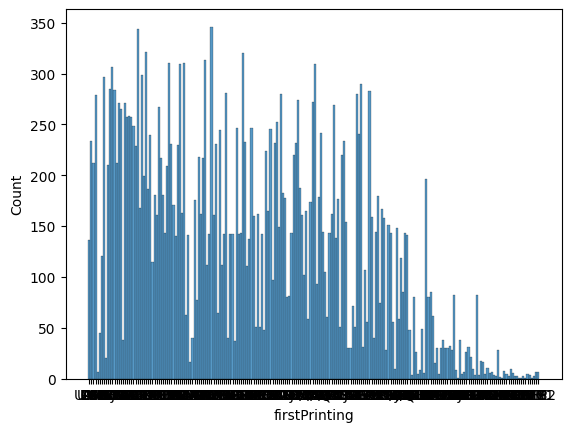

In [19]:
import seaborn as sns
sns.histplot(data = dict_data, x = 'firstPrinting')

...Huh.

We've learned our second unexpected lesson from our dataset: there are a LOT of Magic: The Gathering card sets!  214 sets, to be exact!

In [20]:
dict_data['firstPrinting'].nunique()

214

Taking a closer look at our chart, clutter notwithstanding, we can also see that the y-axis value corresponding to a given x-axis value fluctuates pretty substantially.  This indicates thatWe'll obviously need to 